<a href="https://colab.research.google.com/github/SharlotteManganye/Deep-Learning-CNN/blob/main/MNIST_Project_20250310.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libraries

In [1]:
# visualization tools
import matplotlib.pyplot as plt

# torch- Our deep learning framework
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split
from torch import optim
import torch.nn.functional as F
import math
import numpy as np


In [2]:
print(torch.cuda.is_available())  # Should print True if GPU is available
# Check if CUDA is available before getting device name
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))  # Prints the name of the GPU using get_device_name
else:
    print("CUDA is not available. No GPU device found.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


True
Tesla T4


**Inputs**

In [11]:
batch_size = 128
epochs = 20
seed = 42 # so I can reproduce the results
epsilon = 1e-8
grad_eps = 1e-3
clip_factor = 0.01
learning_rate = 1e-3


**Load Dataset**

In [4]:

def create_train_val_loaders(train_dataset, val_ratio=0.2, batch_size=batch_size, num_workers=2, seed=seed):
    """
    Splits the training data into train and validation sets, creates DataLoaders for train and validation.

    Args:
        train_dataset (torch.utils.data.Dataset): The original training dataset.
        val_ratio (float): The ratio of the training data to use for validation.
        batch_size (int): The batch size for the DataLoaders.
        num_workers (int): The number of workers for the DataLoaders.
        seed (int): The random seed for consistent splits.

    Returns:
        tuple: (train_loader, val_loader)
    """

    total_train_size = len(train_dataset)
    val_size = int(val_ratio * total_train_size)
    train_size = total_train_size - val_size

    generator = torch.Generator().manual_seed(seed)
    train_subset, val_subset = random_split(train_dataset, [train_size, val_size], generator=generator)

    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )

    val_loader = DataLoader(
        val_subset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    return train_loader, val_loader



In [5]:
###LOAD THE DATA
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)

test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 492kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.58MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.89MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [6]:

# Create DataLoaders
train_loader, val_loader = create_train_val_loaders(train_data)
test_loader = torch.utils.data.DataLoader(test_data,
            batch_size=batch_size,
   shuffle=True,

num_workers=1, pin_memory=True) # Pin memory for data)


In [ ]:

print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [ ]:
print(test_data)

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


***1. Standard CNN as Baseline ***

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Feature extraction (convolution)
        self.cnn_model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),  # Removed padding
            nn.BatchNorm2d(32),  # Batch norm after Conv2d
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3),  # Removed padding
            nn.BatchNorm2d(64),  # Batch norm after Conv2d
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
              )

        # Calculate the correct input size for the fully connected layer dynamically
        self.fc_input_size = self._calculate_fc_input_size()
        self.bn1 = nn.BatchNorm2d(32) # Batch norm
        self.bn2 = nn.BatchNorm2d(64) # Batch norm
        self.dropout1 = nn.Dropout(0.25)  # Dropout after CNN
        self.dropout2 = nn.Dropout(0.5)  # Dropout in FC layers

        # Fully connected layer
        self.fc_model = nn.Sequential(
            nn.Linear(self.fc_input_size, 128),
            nn.BatchNorm1d(128),  # Batch norm in FC layers
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout in FC layers
            nn.Linear(128, 10)  # Output size is 10 for 10 classes (digits 0-9)

            )

    def _calculate_fc_input_size(self):
      """Calculates the size of the flattened feature map after convolutions."""
      # Create a dummy input tensor to trace the size changes
      dummy_input = torch.randn(1, 1, 28, 28)  # Assuming input image size is 28x28
      output = self.cnn_model(dummy_input)
      return output.view(1, -1).size(1)


    def forward(self, x):
        x = self.cnn_model(x)  # Feature extraction
        x = self.dropout1(x) # Dropout after CNN layers.
        x = x.view(x.size(0), -1)  # Flatten the inputs
        x = self.fc_model(x)  # Fully connected layers
        return F.log_softmax(x, dim=1)  # Softmax activation for classification

In [ ]:
model = CNN()

# loss function
loss_func = nn.CrossEntropyLoss()
# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr = 1e-3)



####TRAIN
def train(epoch):

    # Setting model in training mode.
    model.train()

    train_loss = 0
    train_acc = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        #clear gradient
        optimizer.zero_grad()

        #FP (make a prediction)
        output = model(data.float())

        # calculating the loss
        loss = loss_func(output, target)

        #BP, Computing the gradient of the loss w.r.t the parameters of the model
        loss.backward()

        # a single step of optimization, update parameters
        optimizer.step()

        train_loss += loss.item()

        _, pred = output.max(1)
        train_acc += target.eq(pred).sum().item()

    train_acc /= len(train_loader.dataset)
    train_loss /= (batch_idx + 1) # Average per batch

    return train_loss, train_acc
###TEST

def val():
    # setting model in evaluation mode.
    model.eval()

    val_loss = 0
    val_acc = 0

    # no gradient is needed
    # when calling a PyTorch neural network to compute output during TRAINING, you should NEVER use the no_grad() statement,
    # but when NOT TRAINING, using the no_grad() statement is optional but more principled.
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):

            #FP
            output = model(data.float())

            # loss
            val_loss += loss_func(output, target).item()
            _, pred = output.max(1)
            val_acc += target.eq(pred).sum().item()

    val_loss /= (batch_idx + 1) # Average per batch
    val_acc /= len(val_loader.dataset)
    return val_loss, val_acc

###PLOT
loss_list = []
val_loss_list = []

acc_list = []
val_acc_list = []

epochs = 10
for epoch in range(1, epochs + 1):
    print("--- Epoch {} ---".format(epoch))

    train_loss, train_acc = train(epoch)
    print('\tTrain loss: {:.4f}, acc: {:.4f}%'.format(train_loss, train_acc))
    loss_list.append(train_loss)
    acc_list.append(train_acc)

    val_loss, val_acc =  val()
    print('\tVal loss: {:.4f}, acc: {:.4f}%'.format(val_loss, val_acc))
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

# plot


x = range(1, epochs + 1)

plt.figure(figsize=(16, 5))

#loss
plt.subplot(1,2,1)
plt.plot(x, loss_list, 'b', label = 'train')
plt.plot(x, val_loss_list, 'r', label = 'val')
plt.title('LOSS')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

#Accuracy
plt.subplot(1,2,2)
plt.plot(x, acc_list, 'b', label = 'train')
plt.plot(x, val_acc_list, 'r', label = 'val')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

NameError: name 'CNN' is not defined

**2. PU-CNN**

In [ ]:
class ProductConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super(ProductConv2d, self).__init__()
        self.weights_u = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size)) # for positive inputs
        self.weights_v = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size)) # for indicator function
        self.stride = stride
        # Initialize weights (important!)
        nn.init.kaiming_uniform_(self.weights_u, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.weights_v, a=math.sqrt(5))

    def forward(self, x):
        batch_size, in_channels, in_height, in_width = x.size()
        kernel_size = self.weights_u.shape[2]
        out_channels = self.weights_u.shape[0]

        out_height = (in_height - kernel_size) // self.stride + 1
        out_width = (in_width - kernel_size) // self.stride + 1

        # Unfold the input tensor
        unfolded = F.unfold(x, kernel_size=kernel_size, stride=self.stride)
        unfolded = unfolded.view(batch_size, in_channels * kernel_size * kernel_size, out_height * out_width)

        # Weights for positive input component
        weights_u_reshaped = self.weights_u.view(out_channels, -1)

        # Logarithm of absolute value
        log_abs_unfolded = torch.log(torch.abs(unfolded) + 1e-10)  # Add small constant for numerical stability

        # Compute the exponential part (corresponding to Eq. 3)
        exp_term = torch.exp(torch.einsum("oc,bcp->bop", weights_u_reshaped, log_abs_unfolded))

        # Weights for indicator function
        weights_v_reshaped = self.weights_v.view(out_channels, -1)

        # Indicator function (vectorized)
        indicator = (unfolded < 0).float()

        # Compute the cosine term (corresponding to Eq. 4)
        cosine_term = torch.cos(math.pi * torch.einsum("oc,bcp->bop", weights_v_reshaped, indicator)).view(batch_size, out_channels, out_height, out_width)

        # Combine the terms
        output = exp_term.view(batch_size, out_channels, out_height, out_width) * cosine_term

        return output


In [ ]:
# Define the PI_CNN class
class PI_CNN(nn.Module):
    def __init__(self):
        super(PI_CNN, self).__init__()
        self.product_conv1 = ProductConv2d(1, 32, kernel_size=3)
        self.product_conv2 = ProductConv2d(32, 64, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32) # Batch norm
        self.bn2 = nn.BatchNorm2d(64) # Batch norm
        self.dropout1 = nn.Dropout(0.25)  # Dropout
        self.dropout2 = nn.Dropout(0.5)  # Dropout in FC layers

        self.fc_input_size = self._calculate_fc_input_size() # Calculate here!

        # Fully connected layer
        self.fc_model = nn.Sequential(
            nn.Linear(self.fc_input_size, 128),
            nn.BatchNorm1d(128),  # Batch norm in FC layers
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout in FC layers
            nn.Linear(128, 10)  # Output size is 10 for 10 classes (digits 0-9)
        )

    def _calculate_fc_input_size(self):
        """Calculates the size of the flattened feature map after convolutions."""
        dummy_input = torch.randn(1, 1, 28, 28)  # Assuming input image size is 28x28. ADJUST IF NEEDED.
        x = self.product_conv1(dummy_input)
        x = self.bn1(x) # Apply Batch Norm
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.product_conv2(x)
        x = self.bn2(x) # Apply Batch Norm
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        return x.view(1, -1).size(1)

    def forward(self, x):
        ###PI Units layer 1
        x = self.product_conv1(x)
        x = self.bn1(x) # Apply Batch Norm
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        ###PI Units layer 2
        x = self.product_conv2(x)
        x = self.bn2(x) # Apply Batch Norm
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x) # Dropout after CNN layers.

        ### MLP
        x = x.view(x.size(0), -1)  # Flatten the inputs
        x = self.fc_model(x)  # Fully connected layers
        return F.log_softmax(x, dim=1)  # Softmax activation for classification


--- Epoch 1 ---
	Train loss: 2.4188, acc: 0.1170%
	Val loss: 2.3670, acc: 0.1981%
--- Epoch 2 ---
	Train loss: 2.2922, acc: 0.1832%
	Val loss: 2.2803, acc: 0.2492%
--- Epoch 3 ---
	Train loss: 2.1710, acc: 0.2763%
	Val loss: 2.1938, acc: 0.3569%
--- Epoch 4 ---
	Train loss: 2.0431, acc: 0.3675%
	Val loss: 2.1241, acc: 0.4214%
--- Epoch 5 ---
	Train loss: 1.9123, acc: 0.4484%
	Val loss: 2.0925, acc: 0.4125%
--- Epoch 6 ---
	Train loss: 1.7705, acc: 0.5199%
	Val loss: 1.9510, acc: 0.5364%
--- Epoch 7 ---
	Train loss: 1.6401, acc: 0.5735%
	Val loss: 1.8247, acc: 0.5829%
--- Epoch 8 ---
	Train loss: 1.5075, acc: 0.6202%
	Val loss: 1.7308, acc: 0.6246%
--- Epoch 9 ---
	Train loss: 1.3720, acc: 0.6654%
	Val loss: 1.5934, acc: 0.6631%
--- Epoch 10 ---
	Train loss: 1.2492, acc: 0.7010%
	Val loss: 1.4640, acc: 0.7094%


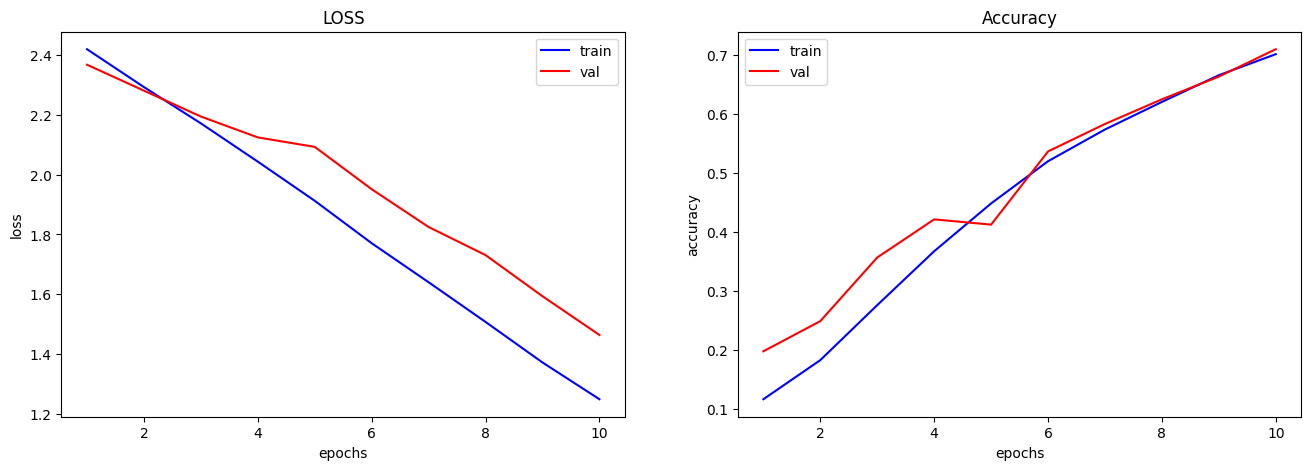

In [ ]:
model = PI_CNN()

# loss function
loss_func = nn.CrossEntropyLoss()
print()
# Adam optimizer
optimizer = optim.Adam(model.parameters(),  lr=1e-5)

####TRAIN
def train(epoch):

    # Setting model in training mode.
    model.train()

    train_loss = 0
    train_acc = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        #clear gradient
        optimizer.zero_grad()

        #FP (make a prediction)
        output = model(data.float())

        # calculating the loss
        loss = loss_func(output, target)

        #BP, Computing the gradient of the loss w.r.t the parameters of the model
        loss.backward()

        # a single step of optimization, update parameters
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  #clamping
        optimizer.step()

        train_loss += loss.item()

        _, pred = output.max(1)
        train_acc += target.eq(pred).sum().item()

    train_acc /= len(train_loader.dataset)
    train_loss /= (batch_idx + 1) # Average per batch

    return train_loss, train_acc
###TEST

def val():
    # setting model in evaluation mode.
    model.eval()

    val_loss = 0
    val_acc = 0

    # no gradient is needed
    # when calling a PyTorch neural network to compute output during TRAINING, you should NEVER use the no_grad() statement,
    # but when NOT TRAINING, using the no_grad() statement is optional but more principled.
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):

            #FP
            output = model(data.float())

            # loss
            val_loss += loss_func(output, target).item()
            _, pred = output.max(1)
            val_acc += target.eq(pred).sum().item()

    val_loss /= (batch_idx + 1) # Average per batch
    val_acc /= len(val_loader.dataset)
    return val_loss, val_acc

###PLOT
loss_list = []
val_loss_list = []

acc_list = []
val_acc_list = []

epochs = 10
for epoch in range(1, epochs + 1):
    print("--- Epoch {} ---".format(epoch))

    train_loss, train_acc = train(epoch)
    print('\tTrain loss: {:.4f}, acc: {:.4f}%'.format(train_loss, train_acc))
    loss_list.append(train_loss)
    acc_list.append(train_acc)

    val_loss, val_acc =  val()
    print('\tVal loss: {:.4f}, acc: {:.4f}%'.format(val_loss, val_acc))
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
# plot


x = range(1, epochs + 1)

plt.figure(figsize=(16, 5))

#loss
plt.subplot(1,2,1)
plt.plot(x, loss_list, 'b', label = 'train')
plt.plot(x, val_loss_list, 'r', label = 'val')
plt.title('LOSS')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

#Accuracy
plt.subplot(1,2,2)
plt.plot(x, acc_list, 'b', label = 'train')
plt.plot(x, val_acc_list, 'r', label = 'val')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

**3.a) PI_SIGMA CNN**

In [ ]:
class PIConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super(PIConv2d, self).__init__()
        self.weights_u = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size)) # for positive inputs
        self.weights_v = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size)) # for indicator function
        self.stride = stride
        # Initialize weights (important!)
        nn.init.kaiming_uniform_(self.weights_u, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.weights_v, a=math.sqrt(5))


    def forward(self, x):
        batch_size, in_channels, in_height, in_width = x.size()
        kernel_size = self.weights_u.shape[2]
        out_channels = self.weights_u.shape[0]

        out_height = (in_height - kernel_size) // self.stride + 1
        out_width = (in_width - kernel_size) // self.stride + 1

        # Unfold the input tensor
        unfolded = F.unfold(x, kernel_size=kernel_size, stride=self.stride)
        unfolded = unfolded.view(batch_size, in_channels * kernel_size * kernel_size, out_height * out_width)

        # Weights for positive input component
        weights_u_reshaped = self.weights_u.view(out_channels, -1)

        # Logarithm of absolute value
        log_abs_unfolded = torch.log(torch.abs(unfolded) + epsilon)  # Add small constant for numerical stability

        # Compute the exponential part (corresponding to Eq. 3)
        exp_term = torch.exp(torch.einsum("oc,bcp->bop", weights_u_reshaped, log_abs_unfolded))

        # Weights for indicator function
        weights_v_reshaped = self.weights_v.view(out_channels, -1)

        # Indicator function (vectorized)
        indicator = (unfolded < 0).float()

        # Compute the cosine term (corresponding to Eq. 4)
        cosine_term = torch.cos(math.pi * torch.einsum("oc,bcp->bop", weights_v_reshaped, indicator)).view(batch_size, out_channels, out_height, out_width)

        # Combine the terms
        output = exp_term.view(batch_size, out_channels, out_height, out_width) * cosine_term

        return output

In [ ]:
class SigmaConv2d(nn.Module):
    def __init__(self):
        super(SigmaConv2d, self).__init__()
        self.product_conv1 = PIConv2d(1, 32, kernel_size=3)
        self.conv1 = nn.Conv2d(32, 64, 3)
        self.conv2 = nn.Conv2d(64, 64, 3)
        self.bn1 = nn.BatchNorm2d(32) # Batch norm after prodconv
        self.bn2 = nn.BatchNorm2d(64) # Batch norm after conv1
        self.dropout1 = nn.Dropout(0.25)  # Dropout
        self.dropout2 = nn.Dropout(0.5)  # Dropout in FC layers

        self.fc_input_size = self._calculate_fc_input_size() # Calculate here!
        # self.bn1 = nn.BatchNorm2d(32) # Batch norm
        # self.bn2 = nn.BatchNorm2d(64) # Batch norm


        # Fully connected layer
        self.fc_model = nn.Sequential(
            nn.Linear(self.fc_input_size, 128),
            nn.BatchNorm1d(128),  # Batch norm in FC layers
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout in FC layers
            nn.Linear(128, 10)  # Output size is 10 for 10 classes (digits 0-9)
        )


    def _calculate_fc_input_size(self):
        """Calculates the size of the flattened feature map after convolutions."""
        dummy_input = torch.randn(1, 1, 28, 28)  # Assuming input image size is 28x28. ADJUST IF NEEDED.
        x = self.product_conv1(dummy_input)
        x = self.bn1(x) # Apply Batch Norm
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv1(x)
        x = self.bn2(x) # Apply Batch Norm
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        return x.view(1, -1).size(1)

    def forward(self, x):
        ###PI Units layer 1
        x = self.product_conv1(x)
        x = self.bn1(x) # Apply Batch Norm
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        ###Sigma Units layer 2
        x = self.conv1(x)
        x = self.bn2(x) # Apply Batch Norm
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        ### MLP
        x = x.view(x.size(0), -1)  # Flatten the inputs
        x = self.fc_model(x)  # Fully connected layers
        return F.log_softmax(x, dim=1)  # Softmax activation for classification


--- Epoch 1 ---
	Train loss: 0.2306, acc: 0.9393%
	Val loss: 0.0506, acc: 0.9841%
--- Epoch 2 ---
	Train loss: 0.0801, acc: 0.9763%
	Val loss: 0.0407, acc: 0.9870%
--- Epoch 3 ---
	Train loss: 0.0642, acc: 0.9801%
	Val loss: 0.0356, acc: 0.9892%
--- Epoch 4 ---
	Train loss: 0.0525, acc: 0.9835%
	Val loss: 0.0340, acc: 0.9886%
--- Epoch 5 ---
	Train loss: 0.0468, acc: 0.9856%
	Val loss: 0.0339, acc: 0.9896%
--- Epoch 6 ---
	Train loss: 0.0414, acc: 0.9869%
	Val loss: 0.0331, acc: 0.9898%
--- Epoch 7 ---
	Train loss: 0.0380, acc: 0.9880%
	Val loss: 0.0319, acc: 0.9896%
--- Epoch 8 ---
	Train loss: 0.0338, acc: 0.9888%
	Val loss: 0.0310, acc: 0.9902%
--- Epoch 9 ---
	Train loss: 0.0299, acc: 0.9902%
	Val loss: 0.0318, acc: 0.9899%
--- Epoch 10 ---
	Train loss: 0.0288, acc: 0.9907%
	Val loss: 0.0321, acc: 0.9902%


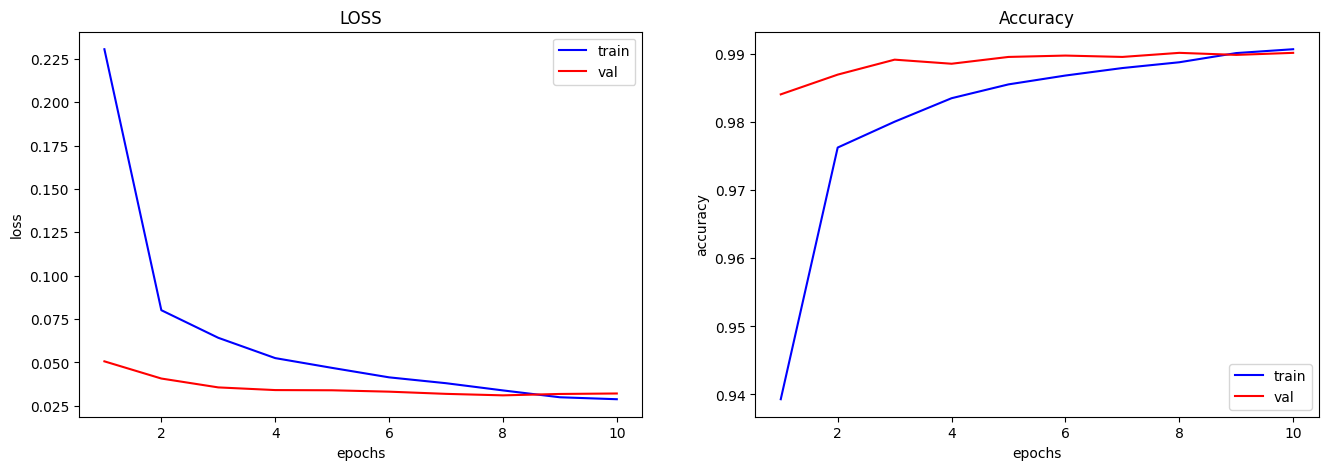

In [ ]:
model = SigmaConv2d()

# loss function
loss_func = nn.CrossEntropyLoss()
# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

####TRAIN
def train(epoch):

    # Setting model in training mode.
    model.train()

    train_loss = 0
    train_acc = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        #clear gradient
        optimizer.zero_grad()

        #FP (make a prediction)
        output = model(data.float())

        # calculating the loss
        loss = loss_func(output, target)

        #BP, Computing the gradient of the loss w.r.t the parameters of the model
        loss.backward()

        # a single step of optimization, update parameters
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  #clamping
        optimizer.step()

        train_loss += loss.item()

        _, pred = output.max(1)
        train_acc += target.eq(pred).sum().item()

    train_acc /= len(train_loader.dataset)
    train_loss /= (batch_idx + 1) # Average per batch

    return train_loss, train_acc
###TEST

def val():
    # setting model in evaluation mode.
    model.eval()

    val_loss = 0
    val_acc = 0

    # no gradient is needed
    # when calling a PyTorch neural network to compute output during TRAINING, you should NEVER use the no_grad() statement,
    # but when NOT TRAINING, using the no_grad() statement is optional but more principled.
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):

            #FP
            output = model(data.float())

            # loss
            val_loss += loss_func(output, target).item()
            _, pred = output.max(1)
            val_acc += target.eq(pred).sum().item()

    val_loss /= (batch_idx + 1) # Average per batch
    val_acc /= len(val_loader.dataset)
    return val_loss, val_acc

###PLOT
loss_list = []
val_loss_list = []

acc_list = []
val_acc_list = []

epochs = 10
for epoch in range(1, epochs + 1):
    print("--- Epoch {} ---".format(epoch))

    train_loss, train_acc = train(epoch)
    print('\tTrain loss: {:.4f}, acc: {:.4f}%'.format(train_loss, train_acc))
    loss_list.append(train_loss)
    acc_list.append(train_acc)

    val_loss, val_acc =  val()
    print('\tVal loss: {:.4f}, acc: {:.4f}%'.format(val_loss, val_acc))
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
# plot


x = range(1, epochs + 1)

plt.figure(figsize=(16, 5))

#loss
plt.subplot(1,2,1)
plt.plot(x, loss_list, 'b', label = 'train')
plt.plot(x, val_loss_list, 'r', label = 'val')
plt.title('LOSS')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

#Accuracy
plt.subplot(1,2,2)
plt.plot(x, acc_list, 'b', label = 'train')
plt.plot(x, val_acc_list, 'r', label = 'val')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

**3.b) Sigma-PI CNN**

In [ ]:
class PIConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super(PIConv2d, self).__init__()
        self.weights_u = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size)) # for positive inputs
        self.weights_v = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size)) # for indicator function
        self.stride = stride
        # Initialize weights (important!)
        nn.init.kaiming_uniform_(self.weights_u, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.weights_v, a=math.sqrt(5))

    def forward(self, x):
        batch_size, in_channels, in_height, in_width = x.size()
        kernel_size = self.weights_u.shape[2]
        out_channels = self.weights_u.shape[0]

        out_height = (in_height - kernel_size) // self.stride + 1
        out_width = (in_width - kernel_size) // self.stride + 1

        # Unfold the input tensor
        unfolded = F.unfold(x, kernel_size=kernel_size, stride=self.stride)
        unfolded = unfolded.view(batch_size, in_channels * kernel_size * kernel_size, out_height * out_width)

        # Weights for positive input component
        weights_u_reshaped = self.weights_u.view(out_channels, -1)

        # Logarithm of absolute value
        log_abs_unfolded = torch.log(torch.abs(unfolded) + epsilon)  # Add small constant for numerical stability

        # Compute the exponential part (corresponding to Eq. 3)
        exp_term = torch.exp(torch.einsum("oc,bcp->bop", weights_u_reshaped, log_abs_unfolded))

        # Weights for indicator function
        weights_v_reshaped = self.weights_v.view(out_channels, -1)

        # Indicator function (vectorized)
        indicator = (unfolded < 0).float()

        # Compute the cosine term (corresponding to Eq. 4)
        cosine_term = torch.cos(math.pi * torch.einsum("oc,bcp->bop", weights_v_reshaped, indicator)).view(batch_size, out_channels, out_height, out_width)

        # Combine the terms
        output = exp_term.view(batch_size, out_channels, out_height, out_width) * cosine_term

        return output

In [ ]:
class SigmaPIConv2d(nn.Module):
    def __init__(self):
        super(SigmaPIConv2d, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, 3)
        self.product_conv1 = PIConv2d(32, 64, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 64, 3)
        self.bn1 = nn.BatchNorm2d(32) # Batch norm after prodconv
        self.bn2 = nn.BatchNorm2d(64) # Batch norm after conv1
        self.dropout1 = nn.Dropout(0.25)  # Dropout after CNN
        self.dropout2 = nn.Dropout(0.5)  # Dropout in FC layers

        self.fc_input_size = self._calculate_fc_input_size() # Calculate here!

        # Fully connected layer
        self.fc_model = nn.Sequential(
            nn.Linear(self.fc_input_size, 128),
            nn.BatchNorm1d(128),  # Batch norm in FC layers
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout in FC layers
            nn.Linear(128, 10)  # Output size is 10 for 10 classes (digits 0-9)
        )


    def _calculate_fc_input_size(self):
        """Calculates the size of the flattened feature map after convolutions."""
        dummy_input = torch.randn(1, 1, 28, 28)  # Assuming input image size is 28x28. ADJUST IF NEEDED.
        x = self.conv1(dummy_input)
        x = self.bn1(x) # Apply Batch Norm
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.product_conv1(x)
        x = self.bn2(x) # Apply Batch Norm
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        return x.view(1, -1).size(1)

    def forward(self, x):
        ###PI Units layer 1
        x = self.conv1(x)
        x = self.bn1(x) # Apply Batch Norm
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        ###Sigma Units layer 2
        x = self.product_conv1(x)
        x = self.bn2(x) # Apply Batch Norm
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        ### MLP
        x = x.view(x.size(0), -1)  # Flatten the inputs
        x = self.fc_model(x)  # Fully connected layers

        return F.log_softmax(x, dim=1)  # Softmax activation for classification


In [ ]:
model = SigmaPIConv2d()

# loss function
loss_func = nn.CrossEntropyLoss()
# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

####TRAIN
def train(epoch):

    # Setting model in training mode.
    model.train()

    train_loss = 0
    train_acc = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        #clear gradient
        optimizer.zero_grad()

        #FP (make a prediction)
        output = model(data.float())

        # calculating the loss
        loss = loss_func(output, target)

        #BP, Computing the gradient of the loss w.r.t the parameters of the model
        loss.backward()

        # a single step of optimization, update parameters
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  #clamping
        optimizer.step()

        train_loss += loss.item()

        _, pred = output.max(1)
        train_acc += target.eq(pred).sum().item()

    train_acc /= len(train_loader.dataset)
    train_loss /= (batch_idx + 1) # Average per batch

    return train_loss, train_acc
###TEST

def val():
    # setting model in evaluation mode.
    model.eval()

    val_loss = 0
    val_acc = 0

    # no gradient is needed
    # when calling a PyTorch neural network to compute output during TRAINING, you should NEVER use the no_grad() statement,
    # but when NOT TRAINING, using the no_grad() statement is optional but more principled.
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):

            #FP
            output = model(data.float())

            # loss
            val_loss += loss_func(output, target).item()
            _, pred = output.max(1)
            val_acc += target.eq(pred).sum().item()

    val_loss /= (batch_idx + 1) # Average per batch
    val_acc /= len(val_loader.dataset)
    return val_loss, val_acc

###PLOT
loss_list = []
val_loss_list = []

acc_list = []
val_acc_list = []

epochs = 10
for epoch in range(1, epochs + 1):
    print("--- Epoch {} ---".format(epoch))

    train_loss, train_acc = train(epoch)
    print('\tTrain loss: {:.4f}, acc: {:.4f}%'.format(train_loss, train_acc))
    loss_list.append(train_loss)
    acc_list.append(train_acc)

    val_loss, val_acc =  val()
    print('\tVal loss: {:.4f}, acc: {:.4f}%'.format(val_loss, val_acc))
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
# plot


x = range(1, epochs + 1)

plt.figure(figsize=(16, 5))

#loss
plt.subplot(1,2,1)
plt.plot(x, loss_list, 'b', label = 'train')
plt.plot(x, val_loss_list, 'r', label = 'val')
plt.title('LOSS')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

#Accuracy
plt.subplot(1,2,2)
plt.plot(x, acc_list, 'b', label = 'train')
plt.plot(x, val_acc_list, 'r', label = 'val')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

--- Epoch 1 ---


KeyboardInterrupt: 

**4. PI_Sigma -CNN (concatination)**




In [ ]:
class PIConv2d(nn.Module):
    def __init__(self, in_channels=1, out_channels=10, kernel_size=3, stride=1):
        super(PIConv2d, self).__init__()
        self.in_channels = in_channels
        self.weights_u = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size)) # for positive inputs
        self.weights_v = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size)) # for indicator function
        self.stride = stride
        # Initialize weights (important!)
        nn.init.kaiming_uniform_(self.weights_u, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.weights_v, a=math.sqrt(5))

    def forward(self, x):
        batch_size, in_channels, in_height, in_width = x.size()
        kernel_size = self.weights_u.shape[2]
        out_channels = self.weights_u.shape[0]

        out_height = (in_height - kernel_size) // self.stride + 1
        out_width = (in_width - kernel_size) // self.stride + 1

        # Unfold the input tensor
        unfolded = F.unfold(x, kernel_size=kernel_size, stride=self.stride)
        unfolded = unfolded.view(batch_size, in_channels * kernel_size * kernel_size, out_height * out_width)

        # Weights for positive input component
        weights_u_reshaped = self.weights_u.view(out_channels, -1)

        # Logarithm of absolute value
        log_abs_unfolded = torch.log(torch.abs(unfolded) + epsilon)  # Add small constant for numerical stability

        # Compute the exponential part (corresponding to Eq. 3)
        exp_term = torch.exp(torch.einsum("oc,bcp->bop", weights_u_reshaped, log_abs_unfolded))

        # Weights for indicator function
        weights_v_reshaped = self.weights_v.view(out_channels, -1)

        # Indicator function (vectorized)
        indicator = (unfolded < 0).float()

        # Compute the cosine term (corresponding to Eq. 4)
        cosine_term = torch.cos(math.pi * torch.einsum("oc,bcp->bop", weights_v_reshaped, indicator)).view(batch_size, out_channels, out_height, out_width)

        # Combine the terms
        output = exp_term.view(batch_size, out_channels, out_height, out_width) * cosine_term

        return output

In [ ]:
class ConcatConv2d(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):  # Add in_channels and num_classes as parameters
        super(ConcatConv2d, self).__init__()
        self.product_conv1 = PIConv2d(in_channels, 16, kernel_size=3)
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)


        self.bn1_conv = nn.BatchNorm2d(16)
        self.bn1_prod = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)

        self.kernel_size = 3  # Consistent kernel size
        self.pooling_size = 2 # Consistent pooling size

        # Calculate fc input size mathematically
        self.fc_input_size = self._calculate_fc_input_size(28, 28) # example for 28x28 images

        self.fc_model = nn.Sequential(
            nn.Linear(self.fc_input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes) # num_classes as parameter
        )

    def _calculate_fc_input_size(self, image_height, image_width):
        # Calculate output size after convolutions and pooling for y and z
        y = torch.randn(1, self.product_conv1.in_channels, image_height, image_width) #dummy input
        y = self.product_conv1(y)
        y = self.bn1_prod(y)
        y = F.relu(y)
        y = F.max_pool2d(y, self.pooling_size)

        z = torch.randn(1, self.conv1.in_channels, image_height, image_width) #dummy input
        z = self.conv1(z)
        z = self.bn1_conv(z)
        z = F.relu(z)
        z = F.max_pool2d(z, self.pooling_size)

        combined_features = torch.cat((y, z), dim=1)
        combined_features = self.conv2(combined_features)
        combined_features = self.bn2(combined_features)
        combined_features = F.relu(combined_features)
        combined_features = F.max_pool2d(combined_features, 2)

        return combined_features.view(1, -1).size(1)

    def forward(self, x):
        y = self.product_conv1(x)
        y = self.bn1_prod(y)
        y = F.relu(y)
        y = F.max_pool2d(y, 2)

        z = self.conv1(x)
        z = self.bn1_conv(z)
        z = F.relu(z)
        z = F.max_pool2d(z, 2)

        if y.shape[2:] != z.shape[2:]:
            z = F.interpolate(z, size=y.shape[2:])

        combined_features = torch.cat((y, z), dim=1)
        combined_features = self.conv2(combined_features)
        combined_features = self.bn2(combined_features)
        combined_features = F.relu(combined_features)
        combined_features = F.max_pool2d(combined_features, 2)

        combined_features = self.dropout1(combined_features)
        combined_features = combined_features.view(combined_features.size(0), -1)  # Correct view

        x = self.fc_model(combined_features)
        return F.log_softmax(x, dim=1)

--- Epoch 1 ---
	Train loss: 0.2080, acc: 0.9469%
	Val loss: 0.0427, acc: 0.9874%
--- Epoch 2 ---
	Train loss: 0.0720, acc: 0.9792%
	Val loss: 0.0332, acc: 0.9895%
--- Epoch 3 ---
	Train loss: 0.0584, acc: 0.9826%
	Val loss: 0.0316, acc: 0.9889%
--- Epoch 4 ---
	Train loss: 0.0483, acc: 0.9851%
	Val loss: 0.0314, acc: 0.9903%
--- Epoch 5 ---
	Train loss: 0.0430, acc: 0.9867%
	Val loss: 0.0291, acc: 0.9901%
--- Epoch 6 ---
	Train loss: 0.0384, acc: 0.9877%
	Val loss: 0.0254, acc: 0.9924%
--- Epoch 7 ---
	Train loss: 0.0354, acc: 0.9890%
	Val loss: 0.0287, acc: 0.9919%
--- Epoch 8 ---
	Train loss: 0.0323, acc: 0.9893%
	Val loss: 0.0268, acc: 0.9918%
--- Epoch 9 ---
	Train loss: 0.0290, acc: 0.9912%
	Val loss: 0.0240, acc: 0.9925%
--- Epoch 10 ---
	Train loss: 0.0259, acc: 0.9915%
	Val loss: 0.0272, acc: 0.9917%


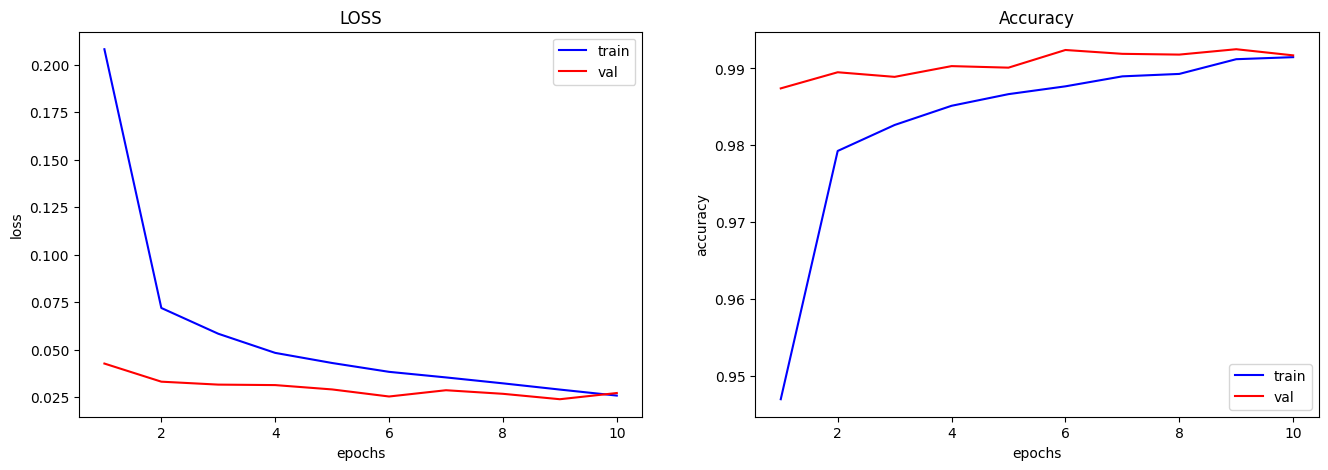

In [ ]:
model = ConcatConv2d()

# loss function
loss_func = nn.CrossEntropyLoss()
# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

####TRAIN
def train(epoch):

    # Setting model in training mode.
    model.train()

    train_loss = 0
    train_acc = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        #clear gradient
        optimizer.zero_grad()

        #FP (make a prediction)
        output = model(data.float())

        # calculating the loss
        loss = loss_func(output, target)

        #BP, Computing the gradient of the loss w.r.t the parameters of the model
        loss.backward()

        # a single step of optimization, update parameters
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  #clamping
        optimizer.step()

        train_loss += loss.item()

        _, pred = output.max(1)
        train_acc += target.eq(pred).sum().item()

    train_acc /= len(train_loader.dataset)
    train_loss /= (batch_idx + 1) # Average per batch

    return train_loss, train_acc
###TEST

def val():
    # setting model in evaluation mode.
    model.eval()

    val_loss = 0
    val_acc = 0

    # no gradient is needed
    # when calling a PyTorch neural network to compute output during TRAINING, you should NEVER use the no_grad() statement,
    # but when NOT TRAINING, using the no_grad() statement is optional but more principled.
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):

            #FP
            output = model(data.float())

            # loss
            val_loss += loss_func(output, target).item()
            _, pred = output.max(1)
            val_acc += target.eq(pred).sum().item()

    val_loss /= (batch_idx + 1) # Average per batch
    val_acc /= len(val_loader.dataset)
    return val_loss, val_acc

###PLOT
loss_list = []
val_loss_list = []

acc_list = []
val_acc_list = []

epochs = 10
for epoch in range(1, epochs + 1):
    print("--- Epoch {} ---".format(epoch))

    train_loss, train_acc = train(epoch)
    print('\tTrain loss: {:.4f}, acc: {:.4f}%'.format(train_loss, train_acc))
    loss_list.append(train_loss)
    acc_list.append(train_acc)

    val_loss, val_acc =  val()
    print('\tVal loss: {:.4f}, acc: {:.4f}%'.format(val_loss, val_acc))
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
# plot


x = range(1, epochs + 1)

plt.figure(figsize=(16, 5))

#loss
plt.subplot(1,2,1)
plt.plot(x, loss_list, 'b', label = 'train')
plt.plot(x, val_loss_list, 'r', label = 'val')
plt.title('LOSS')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

#Accuracy
plt.subplot(1,2,2)
plt.plot(x, acc_list, 'b', label = 'train')
plt.plot(x, val_acc_list, 'r', label = 'val')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

**5. Product Units-Sigma**



In [7]:
class PUConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(PUConv2d, self).__init__()
        self.weights_u = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size)) # for positive inputs
        self.weights_v = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size)) # for indicator function
        self.stride = stride
        self.padding = padding  # Store the padding value
        # Initialize weights (important!)
        nn.init.kaiming_uniform_(self.weights_u, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.weights_v, a=math.sqrt(5))

    def forward(self, x):
        # Apply padding before unfolding
        x = F.pad(x, (self.padding, self.padding, self.padding, self.padding))

        batch_size, in_channels, in_height, in_width = x.size()
        kernel_size = self.weights_u.shape[2]
        out_channels = self.weights_u.shape[0]

        out_height = (in_height - kernel_size) // self.stride + 1
        out_width = (in_width - kernel_size) // self.stride + 1

        # Unfold the input tensor
        unfolded = F.unfold(x, kernel_size=kernel_size, stride=self.stride)
        unfolded = unfolded.view(batch_size, in_channels * kernel_size * kernel_size, out_height * out_width)

        # Weights for positive input component
        weights_u_reshaped = self.weights_u.view(out_channels, -1)

        # Logarithm of absolute value
        log_abs_unfolded = torch.log(torch.abs(unfolded) + epsilon)  # Add small constant for numerical stability

        # Compute the exponential part (corresponding to Eq. 3)
        exp_term = torch.exp(torch.einsum("oc,bcp->bop", weights_u_reshaped, log_abs_unfolded))

        # Weights for indicator function
        weights_v_reshaped = self.weights_v.view(out_channels, -1)

        # Indicator function (vectorized)
        indicator = (unfolded < 0).float()

        # Compute the cosine term (corresponding to Eq. 4)
        cosine_term = torch.cos(math.pi * torch.einsum("oc,bcp->bop", weights_v_reshaped, indicator)).view(batch_size, out_channels, out_height, out_width)

        # Combine the terms
        output = exp_term.view(batch_size, out_channels, out_height, out_width) * cosine_term

        return output

In [8]:
class SigmaPUConv2d(nn.Module):
    def __init__(self, in_channels=1, num_classes=10, image_height=28, image_width=28):
        super(SigmaPUConv2d, self).__init__()
        self.product_conv1 = PUConv2d(in_channels, 16, kernel_size=3)
        self.conv1 = nn.Conv2d(in_channels, 16, 3)
        self.bn1_prod = nn.BatchNorm2d(16)
        self.bn1 = nn.BatchNorm2d(16)
        self.dropout1 = nn.Dropout(0.25)

        self.product_conv2 = PUConv2d(32, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.bn2_prod = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.dropout2 = nn.Dropout(0.25)

        self.product_conv3 = PUConv2d(64, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.bn3_prod = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(64)
        self.dropout3 = nn.Dropout(0.25)

        self.product_conv4 = PUConv2d(128, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 128, 3)
        self.bn4_prod = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(128)
        self.dropout4 = nn.Dropout(0.25)

        self.bn_final = nn.BatchNorm2d(256)

        self.image_height = image_height
        self.image_width = image_width

        self.fc_input_size = self._calculate_fc_input_size()

        self.fc_model = nn.Sequential(
            nn.Linear( self.fc_input_size, 128),  # Use fc_input_size here
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
            )
    def _conv_block(self, x, conv, bn, pool=True):
        x = conv(x)
        x = bn(x)
        x = F.relu(x)
        if pool:
            x = F.max_pool2d(x, 2)
        return x
    def _calculate_fc_input_size(self):
        dummy_input = torch.randn(1, 1, self.image_height, self.image_width) #Correct input size

        y = self._conv_block(dummy_input, self.product_conv1, self.bn1_prod, pool=False)
        z = self._conv_block(dummy_input, self.conv1, self.bn1, pool=False)
        combined_features = torch.cat((y, z), dim=1)

        y2 = self._conv_block(combined_features, self.product_conv2, self.bn2_prod, pool=False)
        z2 = self._conv_block(combined_features, self.conv2, self.bn2, pool=False)
        combined_features2 = torch.cat((y2, z2), dim=1)

        y3 = self._conv_block(combined_features2, self.product_conv3, self.bn3_prod, pool=False)
        z3 = self._conv_block(combined_features2, self.conv3, self.bn3, pool=False)
        combined_features3 = torch.cat((y3, z3), dim=1)

        y4 = self._conv_block(combined_features3, self.product_conv4, self.bn4_prod)
        z4 = self._conv_block(combined_features3, self.conv4, self.bn4)
        combined_features4 = torch.cat((y4, z4), dim=1)

        combined_features4 = self.bn_final(combined_features4)
        combined_features4 = F.relu(combined_features4)
        # combined_features4 = F.max_pool2d(combined_features4, 2) # Added pooling.

        return combined_features4.view(1, -1).size(1)

    def forward(self, x):
        y = self._conv_block(x, self.product_conv1, self.bn1_prod, pool=False)
        z = self._conv_block(x, self.conv1, self.bn1, pool=False)
        combined_features = torch.cat((y, z), dim=1)


        y2 = self._conv_block(combined_features, self.product_conv2, self.bn2_prod, pool=False)
        z2 = self._conv_block(combined_features, self.conv2, self.bn2, pool=False)
        combined_features2 = torch.cat((y2, z2), dim=1)


        y3 = self._conv_block(combined_features2, self.product_conv3, self.bn3_prod, pool=False)
        z3 = self._conv_block(combined_features2, self.conv3, self.bn3, pool=False)
        combined_features3 = torch.cat((y3, z3), dim=1)


        y4 = self._conv_block(combined_features3, self.product_conv4, self.bn4_prod)
        z4 = self._conv_block(combined_features3, self.conv4, self.bn4)
        combined_features4 = torch.cat((y4, z4), dim=1)


        combined_features4 = self.bn_final(combined_features4)
        combined_features4 = F.relu(combined_features4)
        # combined_features4 = F.max_pool2d(combined_features4, 2) # Added pooling.


        combined_features4 = combined_features4.view(combined_features4.size(0), -1)


        x = self.fc_model(combined_features4)
        return F.log_softmax(x, dim=1)

--- Epoch 1 ---


<ipython-input-12-39d0aa07821b>:29: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


	Train loss: 2.2647, acc: 0.1521%
	Val loss: 2.2729, acc: 0.1746%
--- Epoch 2 ---
	Train loss: 2.1239, acc: 0.2461%
	Val loss: 2.2418, acc: 0.2507%
--- Epoch 3 ---
	Train loss: 2.0028, acc: 0.3211%
	Val loss: 2.2175, acc: 0.2996%
--- Epoch 4 ---
	Train loss: 1.9031, acc: 0.3764%
	Val loss: 2.1899, acc: 0.3583%
--- Epoch 5 ---
	Train loss: 1.8247, acc: 0.4150%
	Val loss: 2.1481, acc: 0.4082%
--- Epoch 6 ---
	Train loss: 1.7435, acc: 0.4520%
	Val loss: 2.1188, acc: 0.4281%
--- Epoch 7 ---
	Train loss: 1.6733, acc: 0.4839%
	Val loss: 2.0804, acc: 0.4691%
--- Epoch 8 ---
	Train loss: 1.6014, acc: 0.5095%
	Val loss: 2.0319, acc: 0.5075%
--- Epoch 9 ---
	Train loss: 1.5299, acc: 0.5416%
	Val loss: 1.9605, acc: 0.5298%
--- Epoch 10 ---
	Train loss: 1.4569, acc: 0.5705%
	Val loss: 1.8935, acc: 0.5734%
--- Epoch 11 ---
	Train loss: 1.3831, acc: 0.5974%
	Val loss: 1.8639, acc: 0.6014%
--- Epoch 12 ---
	Train loss: 1.3111, acc: 0.6228%
	Val loss: 1.8626, acc: 0.6025%
--- Epoch 13 ---
	Train loss:

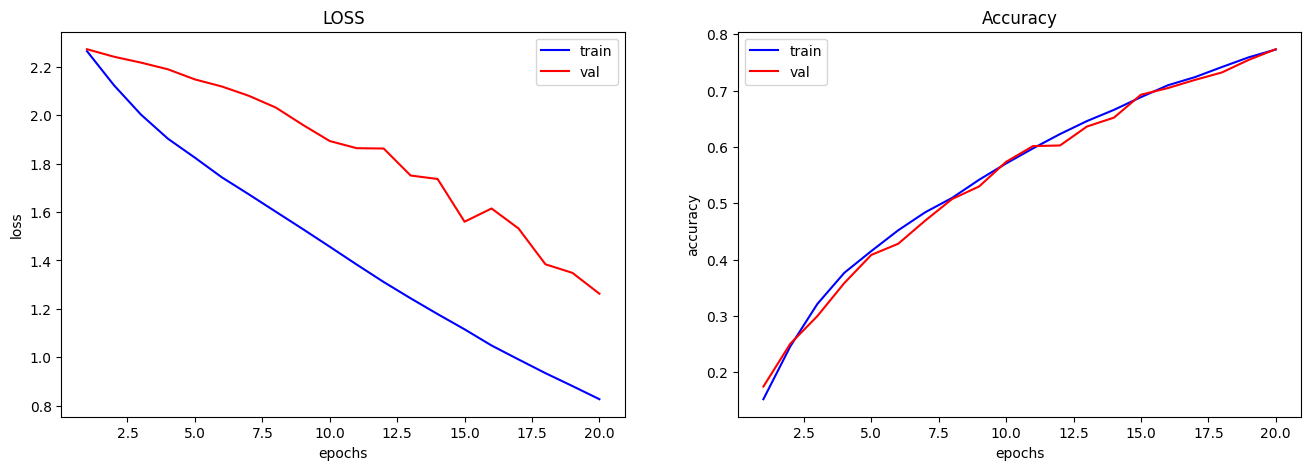

In [12]:
model = SigmaPUConv2d().to(device)
# loss function
loss_func = nn.CrossEntropyLoss()
# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr = 1e-6)

#Alternative Adaptive Gradient Clipping (Norm Based)
def adaptive_clip_grad_norm(parameters, clip_factor=clip_factor, eps=grad_eps):
    if not isinstance(parameters, torch.Tensor):
        parameters = list(filter(lambda p: p.grad is not None, parameters))
    if not parameters:
        return

    device = parameters[0].device
    total_norm = torch.norm(torch.stack([torch.norm(p.grad.detach()).to(device) for p in parameters]))
    clip_coef = (clip_factor * total_norm) / (total_norm + eps)
    if clip_coef < 1:
        for p in parameters:
            p.grad.detach().mul_(clip_coef.to(p.grad.device))

####TRAIN
def train(epoch):

    # Setting model in training mode.
    model.train()

    train_loss = 0
    train_acc = 0
    scaler = torch.cuda.amp.GradScaler()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        #clear gradient
        optimizer.zero_grad()

        #FP (make a prediction)
        output = model(data.float())

        # calculating the loss
        loss = loss_func(output, target)

        # BP, Computing the gradient of the loss w.r.t the parameters of the model
        loss.backward()

        # a single step of optimization, update parameters
        adaptive_clip_grad_norm(model.parameters())
        optimizer.step()

        train_loss += loss.item()

        _, pred = output.max(1)
        train_acc += target.eq(pred).sum().item()

    train_acc /= len(train_loader.dataset)
    train_loss /= (batch_idx + 1) # Average per batch

    return train_loss, train_acc
###TEST

def val():
    # setting model in evaluation mode.
    model.eval()

    val_loss = 0
    val_acc = 0

    # no gradient is needed
    # when calling a PyTorch neural network to compute output during TRAINING, you should NEVER use the no_grad() statement,
    # but when NOT TRAINING, using the no_grad() statement is optional but more principled.
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
            #FP
            output = model(data.float())

            # loss
            val_loss += loss_func(output, target).item()
            _, pred = output.max(1)
            val_acc += target.eq(pred).sum().item()

    val_loss /= (batch_idx + 1) # Average per batch
    val_acc /= len(val_loader.dataset)
    return val_loss, val_acc

###PLOT
loss_list = []
val_loss_list = []

acc_list = []
val_acc_list = []

for epoch in range(1, epochs + 1):
    print("--- Epoch {} ---".format(epoch))

    train_loss, train_acc = train(epoch)
    print('\tTrain loss: {:.4f}, acc: {:.4f}%'.format(train_loss, train_acc))
    loss_list.append(train_loss)
    acc_list.append(train_acc)

    val_loss, val_acc =  val()
    print('\tVal loss: {:.4f}, acc: {:.4f}%'.format(val_loss, val_acc))
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
# plot


x = range(1, epochs + 1)

plt.figure(figsize=(16, 5))

#loss
plt.subplot(1,2,1)
plt.plot(x, loss_list, 'b', label = 'train')
plt.plot(x, val_loss_list, 'r', label = 'val')
plt.title('LOSS')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

#Accuracy
plt.subplot(1,2,2)
plt.plot(x, acc_list, 'b', label = 'train')
plt.plot(x, val_acc_list, 'r', label = 'val')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()